In [1]:
import math
import timeit
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio

In [2]:
# Function to display images
def display_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to resize an image using bilinear interpolation
def bilinear_interpolation(image_matrix, new_height, new_width):
    orig_height, orig_width, num_channels = image_matrix.shape
    resized_image_matrix = np.zeros((new_height, new_width, num_channels), dtype=np.uint8)

    x_ratio = float(orig_width - 1) / (new_width - 1)
    y_ratio = float(orig_height - 1) / (new_height - 1)

    for i in range(new_height):
        for j in range(new_width):
            x_l, y_l = int(x_ratio * j), int(y_ratio * i)
            x_h, y_h = min(x_l + 1, orig_width - 1), min(y_l + 1, orig_height - 1)

            x_weight = (x_ratio * j) - x_l
            y_weight = (y_ratio * i) - y_l

            for ch in range(num_channels):
                a = image_matrix[y_l, x_l, ch]
                b = image_matrix[y_l, x_h, ch]
                c = image_matrix[y_h, x_l, ch]
                d = image_matrix[y_h, x_h, ch]

                pixel = (a * (1 - x_weight) * (1 - y_weight) +
                         b * x_weight * (1 - y_weight) +
                         c * (1 - x_weight) * y_weight +
                         d * x_weight * y_weight)

                resized_image_matrix[i, j, ch] = pixel

    return resized_image_matrix

# Function to resize an image back to its original dimensions using bilinear interpolation
def resize_image_to_original(resized_image_matrix, orig_height, orig_width):
    return bilinear_interpolation(resized_image_matrix, orig_height, orig_width)


Original Height: 1200
Original Width: 1920


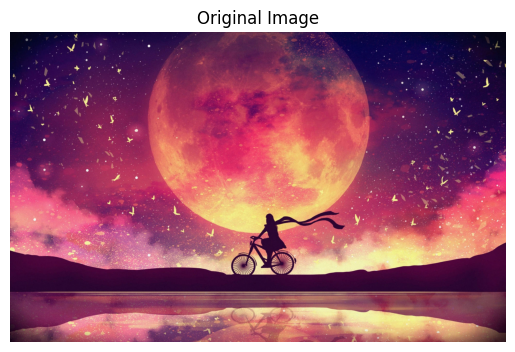

In [3]:
# Load the image
image_path = '/content/sample.jpg'
image = Image.open(image_path)
image_matrix = np.array(image)

# Print original dimensions
orig_height, orig_width, _ = image_matrix.shape
print("Original Height:", orig_height)
print("Original Width:", orig_width)

# Display the original image
display_image(image, 'Original Image')



Resized Height: 300
Resized Width: 300


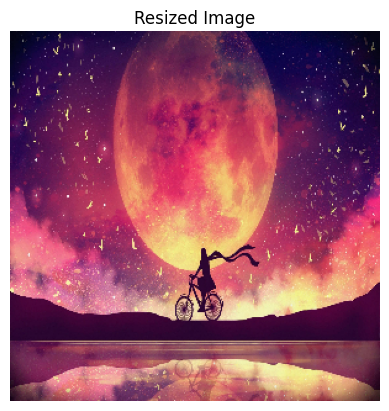

Resizing execution time: 9.104732 seconds


In [4]:
# Define new dimensions for resizing
new_height = 300
new_width = 300

# Perform resizing (either downsampling or upsampling) and measure the time
start_time = timeit.default_timer()
resized_image_matrix = bilinear_interpolation(image_matrix, new_height, new_width)
end_time = timeit.default_timer()

# Convert the resized matrix back to an image
resized_image = Image.fromarray(resized_image_matrix)

# Print new dimensions
print("\nResized Height:", new_height)
print("Resized Width:", new_width)

# Display the resized image
display_image(resized_image, 'Resized Image')

# Print the execution time for resizing
execution_time = end_time - start_time
print(f"Resizing execution time: {execution_time:.6f} seconds")


In [5]:
# Resize the resized image back to original dimensions for other calculation
start_time = timeit.default_timer()
resized_back_image_matrix = resize_image_to_original(resized_image_matrix, orig_height, orig_width)
end_time = timeit.default_timer()

# Convert the resized back matrix back to an image
resized_back_image = Image.fromarray(resized_back_image_matrix)

# Print the execution time for resizing back to original
execution_time_back = end_time - start_time
print(f"Resizing back to original execution time: {execution_time_back:.6f} seconds")


Resizing back to original execution time: 81.368741 seconds


In [6]:
# Function to calculate and print PSNR
def calculate_psnr(original_image_matrix, processed_image_matrix):
    psnr_value = peak_signal_noise_ratio(original_image_matrix, processed_image_matrix)
    return psnr_value

# Define a function to calculate MSE
def calculate_mse_manual(y_true, y_pred):

    n = len(y_true)
    squared_diff = np.sum((y_true - y_pred) ** 2)
    return squared_diff / n

# Flatten images to 1D arrays
y_true = image_matrix.flatten()
y_pred = resized_back_image_matrix.flatten()

In [7]:
# Calculate MSE
mse = np.mean((image_matrix - resized_back_image_matrix) ** 2)
print("Mean Squared Error (built in):", mse)

# Calculate MSE manually
mse_manual = calculate_mse_manual(y_true, y_pred)
print(f"Mean Squared Error (manual): {mse_manual:}")


Mean Squared Error (built in): 24.651955873842592
Mean Squared Error (manual): 24.651955873842592


In [8]:
# Ensure that image_matrix and resized_back_image_matrix have the same dtype and range
print(f"Image matrix dtype: {image_matrix.dtype}, range: {image_matrix.min()} to {image_matrix.max()}")
print(f"Resized back image matrix dtype: {resized_back_image_matrix.dtype}, range: {resized_back_image_matrix.min()} to {resized_back_image_matrix.max()}")

# Normalize images to the range [0, 1] if necessary
image_matrix_normalized = image_matrix / np.max(image_matrix)
resized_back_image_matrix_normalized = resized_back_image_matrix / np.max(resized_back_image_matrix)

# Flatten images to 1D arrays
y_true = image_matrix_normalized.flatten()
y_pred = resized_back_image_matrix_normalized.flatten()

# Calculate MSE manually
mse_manual = np.mean((y_true - y_pred) ** 2)

# Calculate PSNR manually
max_pixel_value = 1  # Since images are normalized to [0, 1]
psnr_manual = 20 * math.log10(max_pixel_value / math.sqrt(mse_manual))
print(f"\nPSNR (manual): {psnr_manual:} dB")

# Calculate PSNR using skimage.metrics
psnr_skimage = peak_signal_noise_ratio(image_matrix_normalized, resized_back_image_matrix_normalized, data_range=1)
print(f"PSNR (skimage): {psnr_skimage:} dB")


Image matrix dtype: uint8, range: 0 to 255
Resized back image matrix dtype: uint8, range: 0 to 254

PSNR (manual): 27.888547577322814 dB
PSNR (skimage): 27.888547577322814 dB


In [9]:
# Calculate SSIM using skimage.metrics with channel_axis instead of multichannel
ssim_value, ssim_map = structural_similarity(image_matrix_normalized, resized_back_image_matrix_normalized, full=True, channel_axis=2)
print(f"SSIM: {ssim_value:.4f}")


SSIM: 0.8934


In [10]:
# Calculate RR Sim (custom definition)
rr_sim = np.sum(np.abs(image_matrix_normalized - resized_back_image_matrix_normalized)) / y_true.size
print(f"RR Sim: {rr_sim:.4f}")


RR Sim: 0.0191


In [11]:
import pywt

def calculate_wavelet_rr(original_image, processed_image):
    # Perform DWT on both images
    coeffs_original = pywt.dwt2(original_image, 'haar')
    coeffs_processed = pywt.dwt2(processed_image, 'haar')

    # Extract approximation coefficients
    cA_orig, (cH_orig, cV_orig, cD_orig) = coeffs_original
    cA_proc, (cH_proc, cV_proc, cD_proc) = coeffs_processed

    # Calculate the sum of absolute differences for each type of coefficient
    diff_cA = np.sum(np.abs(cA_orig - cA_proc))
    diff_cH = np.sum(np.abs(cH_orig - cH_proc))
    diff_cV = np.sum(np.abs(cV_orig - cV_proc))
    diff_cD = np.sum(np.abs(cD_orig - cD_proc))

    # Combine the differences
    wavelet_rr = (diff_cA + diff_cH + diff_cV + diff_cD) / (cA_orig.size + cH_orig.size + cV_orig.size + cD_orig.size)
    return wavelet_rr

# Convert images to grayscale for wavelet transform
original_image_gray = np.mean(image_matrix, axis=2) / 255.0
processed_image_gray = np.mean(resized_back_image_matrix, axis=2) / 255.0

# Calculate Wavelet-Based RR
wavelet_rr_value = calculate_wavelet_rr(original_image_gray, processed_image_gray)
print(f"Wavelet-Based RR: {wavelet_rr_value:.4f}")


Wavelet-Based RR: 0.0150


In [12]:
import numpy as np
from skimage import io, color, util
from scipy.stats import skew, kurtosis

# Convert images to grayscale
original_image_gray = color.rgb2gray(image_matrix)
processed_image_gray = color.rgb2gray(resized_back_image_matrix)

# Normalize images to [0, 255]
original_image_norm = util.img_as_ubyte(original_image_gray)
processed_image_norm = util.img_as_ubyte(processed_image_gray)

# Compute image statistics
def compute_brisque_features(image):
    features = []

    # Mean and variance
    mean = np.mean(image)
    var = np.var(image)
    features.extend([mean, var])

    # Skewness and Kurtosis
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())
    features.extend([skewness, kurt])

    return features

# Calculate BRISQUE features for both images
brisque_features_orig = compute_brisque_features(original_image_norm)
brisque_features_proc = compute_brisque_features(processed_image_norm)

# BRISQUE score calculation
def calculate_brisque_score(features):
    weights = np.array([0.1, 0.2, 0.2, 0.2])
    mean_ref = np.array([120.0, 2000.0, 0.02, 0.002])

    normalized_features = (np.array(features) - mean_ref) * weights
    score = np.sum(np.square(normalized_features))

    return score

# Calculate BRISQUE scores
brisque_score_orig = calculate_brisque_score(brisque_features_orig)
brisque_score_proc = calculate_brisque_score(brisque_features_proc)

print(f"BRISQUE Score - Original Image: {brisque_score_orig:.2f}")
print(f"BRISQUE Score - Processed Image: {brisque_score_proc:.2f}")


BRISQUE Score - Original Image: 102272.81
BRISQUE Score - Processed Image: 82777.53


In [13]:
import numpy as np
from skimage import color, util
from scipy.stats import skew, kurtosis

# Convert images to grayscale
original_image_gray = color.rgb2gray(image_matrix)
processed_image_gray = color.rgb2gray(resized_back_image_matrix)

# Normalize images to [0, 255]
original_image_norm = util.img_as_ubyte(original_image_gray)
processed_image_norm = util.img_as_ubyte(processed_image_gray)

# Compute image statistics
def compute_niqe_features(image):
    features = []

    # Mean and variance
    mean = np.mean(image)
    var = np.var(image)
    features.extend([mean, var])

    # Skewness and Kurtosis
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())
    features.extend([skewness, kurt])

    return features

# Calculate NIQE features for both images
niqe_features_orig = compute_niqe_features(original_image_norm)
niqe_features_proc = compute_niqe_features(processed_image_norm)

# Calculate NIQE score
def calculate_niqe_score(features):
    weights = np.array([0.02, 0.1, 0.01, 0.01])  # Adjust weights as needed
    mean_ref = np.array([127.0, 1600.0, 0.0, 0.0])  # Adjust mean reference values as needed

    normalized_features = (np.array(features) - mean_ref) * weights
    score = np.sum(np.square(normalized_features))

    return score

niqe_score_orig = calculate_niqe_score(niqe_features_orig)
niqe_score_proc = calculate_niqe_score(niqe_features_proc)

print(f"NIQE Score - Original Image: {niqe_score_orig:.2f}")
print(f"NIQE Score - Processed Image: {niqe_score_proc:.2f}")


NIQE Score - Original Image: 39957.35
NIQE Score - Processed Image: 33799.67


BUILT-IN Bilinear Interpolation

In [17]:
import cv2
import numpy as np
import time

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Load the image and convert it to a NumPy array
image = cv2.imread(image_path)
image_matrix_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Measure the time for resizing the image
start_time_resize = time.time()
resized_image_matrix = cv2.resize(image_matrix_orig, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
end_time_resize = time.time()

# Measure the time for resizing the image back to original dimensions
start_time_resize_back = time.time()
resized_back_image_matrix = cv2.resize(resized_image_matrix, (image_matrix_orig.shape[1], image_matrix_orig.shape[0]), interpolation=cv2.INTER_NEAREST)
end_time_resize_back = time.time()

# Calculate MSE between original image and resized-back image
mse_builtin = calculate_mse(image_matrix_orig.flatten(), resized_back_image_matrix.flatten())

# Calculate the time taken for resizing operations
time_resize = end_time_resize - start_time_resize
time_resize_back = end_time_resize_back - start_time_resize_back

print(f"MSE (Built-in Nearest Neighbor): {mse_builtin:}")
print(f"Time for resizing: {time_resize:.6f} seconds")
print(f"Time for resizing back: {time_resize_back:.6f} seconds")


MSE (Built-in Nearest Neighbor): 24.8525625
Time for resizing: 0.001116 seconds
Time for resizing back: 0.003757 seconds
